# Lecture III: Recurrent Neural Network
This homework aims to help you understand Recurrent Neural Network by building a RNN classifier on Japanese Vowels from different male speakers. 

As usual, we will first import some useful modules:

In [2]:
# pylint: disable=E1101,R,C
import numpy as np
import os
import argparse
import time
import math
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.nn import init
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.autograd import Variable
import gzip
import pickle
from scipy import sparse
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler,MinMaxScaler
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchsnooper
from torch.cuda.amp import autocast 
torch.set_default_tensor_type(torch.FloatTensor)

The Japanese Vowel dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/Japanese+Vowels). For a detailed description, please look at this website. First, we will download the dataset:

In [3]:
!wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/JapaneseVowels-mld/ae.train
!wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/JapaneseVowels-mld/ae.test
!wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/JapaneseVowels-mld/size_ae.train
!wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/JapaneseVowels-mld/size_ae.test

File ‘ae.train’ already there; not retrieving.

File ‘ae.test’ already there; not retrieving.

File ‘size_ae.train’ already there; not retrieving.

File ‘size_ae.test’ already there; not retrieving.



This dataset contains 9 male japanese speaker pronouncing the utterance /ae/. The data is decoded by Linear Predictive Coding. A detail of LPC can be found [here](https://en.wikipedia.org/wiki/Linear_predictive_coding). Each utterance contains 12 LPC basis, thus for each time index, the time series will contain 12 channels.

## Part I: Dataset

First, we will need to prepare the dataset using `Dataset()` class. Since in last home work, I have gone through the detail of this class, I will skip most of the technical details.

In [302]:
class JapaneseVowelDataset(Dataset):

    def __init__(self,plot=True):
        self.max_length = 29 # The maximum possible length of each utterance contains 29 samples
        self.num_LPC = 12    # The LPC spectrum contains 12 coefficients, so the data shape will be [29,12]
        
        train_data, train_label = self.read_vowels("ae.train","size_ae.train")
        test_data, test_label = self.read_vowels("ae.test","size_ae.test")
        
        self.size = len(train_data) + len(test_data)
        self.train_test_split = len(train_data)
        
        self.data = train_data + test_data
        self.labels = train_label + test_label
        
        if plot:
            self.plot_data()
        
        
    def __len__(self):
        '''
        This function returns the size of overall dataset
        '''
        return self.size


    def __getitem__(self, idx):
        '''
        This function extract a single entry from the dataset at the given index idx
        In this dataset, the data has variable length, so we need to pad 
        the LPC coefficients to have the same length for training purpose
        '''
        output = np.zeros((self.max_length, self.num_LPC))
        data = self.data[idx]
        output[:data.shape[0]] += data
        return output, self.labels[idx]
    
    def get_train_test_split(self):
        '''
        This function get the train test split size of the dataset
        '''
        return self.train_test_split
    
    def read_vowels(self,file, size_file):
        vowel_units = []
        speaker_size = []
        labels = []
        #Read out the LPC value of all vowels
        with open(file, "r") as f:
            current_vowel = []
            for line in f.readlines():
                if line == '\n':
                    vowel_units.append(np.array(current_vowel))
                    current_vowel = []
                    continue
                current_vowel.append(np.array(line.strip().split(" "),dtype=float).tolist())
        #Read out the size of samples by 9 speakers
        with open(size_file, "r") as f:
            speaker_size = np.array(f.readline().strip().split(" "),dtype=int)
            assert len(speaker_size) == 9 # If speaker size is not 9, then there's something wrong
        #Assign a label to each speaker, speaker 1 == 0 .....speaker 9 == 8:
        for speaker_label in range(9):
            labels += [speaker_label] * speaker_size[speaker_label]
        # Check if the number of label equals to number of data
        # If not, there is something wrong
        assert len(vowel_units) == len(labels)
        return vowel_units, labels
            
                    
        
    
    def plot_data(self):
        '''
        This function plots the LPC spectrum of 9 random utterances
        '''
        plt.figure(figsize=(20,12))
        sample_index = np.random.randint(low=0,high=self.__len__(), size = 9)
        for i in range(9):
            plt.subplot(3,3, i+1)
            voice, label = self.__getitem__(sample_index[i])
            utt_length = voice.shape[0]
            for i in range(voice.shape[-1]):
                plt.plot(np.arange(utt_length), voice[:,i])
            plt.xlabel("Time Index")
            plt.ylabel("LPC Coefficients")

Similarly, we can check the form of data by plotting the LPC spectrum coefficients. The trailing 0s comes from the padding we performed within the dataset:

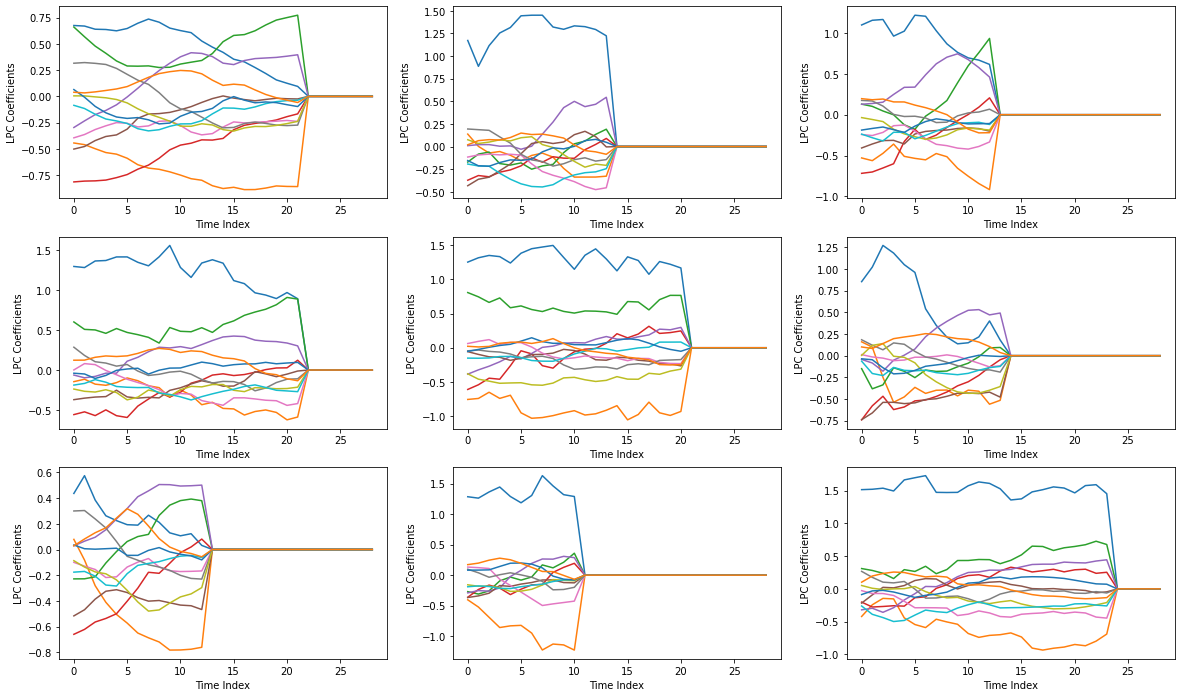

In [303]:
JapaneseVowelDataset()

## Part II: Recurrent Neural Network
In this part, we will buid an LSTM based recurrent neural network model to analyze the input LPC spectrum. Since this is the second time we build a NN, I will leave most of the work to you. Some useful resources include:
- [nn.LSTM](https://pytorch.org/docs/master/generated/torch.nn.LSTM.html#lstm)
- [nn.Linear](https://pytorch.org/docs/master/generated/torch.nn.Linear.html?highlight=linear#torch.nn.Linear)
- [nn.LeakyReLU](https://pytorch.org/docs/master/generated/torch.nn.LeakyReLU.html?highlight=leakyrelu#torch.nn.LeakyReLU)
- [nn.Sequential](https://pytorch.org/docs/master/generated/torch.nn.Sequential.html?highlight=sequential#torch.nn.Sequential)

Some useful tips for building the recurrent neural network:
- Read [nn.LSTM](https://pytorch.org/docs/master/generated/torch.nn.LSTM.html#lstm) carefully, make sure you understand the input and output shape of the LSTM layer. The [nn.LSTM](https://pytorch.org/docs/master/generated/torch.nn.LSTM.html#lstm) layer outputs `output, (h_n, c_n)`:
    -  `output` has a shape of `(Seq_len,Batch_size,num_direction*hidden_size)`, it contains all intermediate hidden state outputs of the last layer. Note that there is a `batch_first` flag in LSTM input which may change the output shape to `(Batch_size,Seq_len,num_direction*hidden_size)`. If you want to select only the last hidden state, you shoud simply index the `Seq_len` dimension.
    -  `(h_n, c_n)` contains the last hidden state outputs of each layers
- Remember that you want to select only the the **last hidden state output**. You can either extract it from `output` or `h_n`.
- Then you will feed the **last hidden state output** into `self.fc_classifier`. You will need to adjust the `hidden_size` of LSTM output and the input size of first fully connected layer in `self.fc_classifier` to match
- Make sure the output of RNN model has the shape of [BATCHSIZE,9], since we have 9 speakers in the dataset we'd like to classify into

In [323]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        '''
        Initialize the RNN. As mentioned in the lecture, RNN contains 2 parts:
            A feature extractor based on LSTM network
            A fully connected classifier
        '''
        hidden_dim = 128
        
        self.feature_extractor = nn.LSTM(input_size=12, hidden_size=hidden_dim, num_layers=2, batch_first=True, bidirectional=True, dropout=0.3)
        
        self.layer_norm = nn.LayerNorm(hidden_dim*2)
        
        self.fc_classifier = nn.Sequential(
            nn.Linear(hidden_dim*2,9),
        )
#     @torchsnooper.snoop()
    def forward(self, x):
        '''
        The forward operation of each training step of the neural network model
        '''
        output, last_state = self.feature_extractor(x)
        last_hidden = self.layer_norm(output)[:,-1]
        x = self.fc_classifier(last_hidden)
        return x

Similar to what we did in Lecture 2 homework, we will pull out 1 event from the dataset, and use `torchsnooper.snoop()` to check the network structure. Before proceeding to the next part, you may want to stare at the tensor output of `torchsnooper.snoop()` carefully to understand how the data is flowing within the RNN network.

In [324]:
#Pull out 1 event from the dataset
test_event, test_label = next(iter(JapaneseVowelDataset(plot=False)))
test_event = torch.FloatTensor(test_event).unsqueeze(0) # Insert batch dimension
test_network = RNN()
print(test_network(test_event,))

tensor([[ 0.4323, -0.9816,  0.2791,  0.3072, -0.1007,  0.6248,  0.0040, -0.6448,
         -0.3889]], grad_fn=<AddmmBackward>)


## Part III: Training
After building the neural network, we train it the same way as we did in Lecture 2:

In [325]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # This says if GPU is available, use GPU, otherwise use CPU
NUM_EPOCHS =20
LEARNING_RATE =1e-3 # 1e-2 is a good learning rate for general purpose
BATCH_SIZE=5

In [326]:
def set_up_classifier():
    classifier = RNN() # Define CNN neural network classifier
    classifier.to(DEVICE)     # Send the classifier to DEVICE as we defined earlier

    print("# of params in model: ", sum(x.numel() for x in classifier.parameters()))

    criterion = torch.nn.CrossEntropyLoss()
    criterion = criterion.to(DEVICE)

    #Define the optimizer
    optimizer = torch.optim.Adam(classifier.parameters(),lr=LEARNING_RATE)
    
    return classifier, criterion, optimizer

In [327]:
def get_dataloader():
    dataset = JapaneseVowelDataset(plot=False)
    #Get the indices of train dataset and test dataset correspondingly, indices [0:train_test_split] is the training dataset, indices [train_test_split, len(dataset)] is the test dataset.
    train_test_split = dataset.get_train_test_split()
    train_indices, val_indices = list(range(train_test_split)), list(range(train_test_split,len(dataset)))

    #Shuffle the two indices list
    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)

    # Define two subset random sampler to sample events according to the training indices
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    # Finally, define the loader by passing in the dataset, batch size and corresponding sampler
    # Note that the number of data in each sub-dataset might not be divisibe by the batch size, so drop_last=True drops the last batch with all the residual events.
    train_loader = data_utils.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler, drop_last=True)
    test_loader = data_utils.DataLoader(dataset, batch_size=BATCH_SIZE,sampler=valid_sampler,  drop_last=True)
    
    return train_loader, test_loader

In [328]:
classifier, criterion, optimizer = set_up_classifier()
train_loader, test_loader = get_dataloader()

loss_values = []
accuracy_values = []
y_true = []
y_pred = []

for epoch in range(NUM_EPOCHS):
    for i, (utterances, labels) in tqdm(enumerate(train_loader)):
        classifier.train() # This line set the neural network to train mode, some layers perform differently in train and test mode.
        
        utterances = utterances.to(DEVICE).float()
        labels = labels.to(DEVICE)
        
        #Train the RNN classifier
        outputs  = classifier(utterances)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Back-propagate loss to update gradient
        loss.backward()
        
        # Perform gradient descent to update parameters
        optimizer.step()
        
        # reset gradient to 0 on all parameters
        optimizer.zero_grad()

    print('\rEpoch [{0}/{1}], Iter [{2}/{3}] Loss: {4:.4f}'.format(
        epoch+1, NUM_EPOCHS, i+1, len(train_loader),
        loss.item(), end=""),end="")
    loss_values.append(loss.item())
    
    #After every epoch, evaluate the validation accuracy on the test loader
    num_accurate = 0
    num_images = 0
    for utterances,labels in tqdm(test_loader):

        classifier.eval() # This line set the neural network to evaluation mode, some layers perform differently in train and test mode.
        
        #While validating the network, we do not want it to produce any gradient. This will also save us time/memory
        with torch.no_grad():
            
            # Convey images to device, then feed it to the neural network for network output
            utterances = utterances.to(DEVICE).float()
            outputs  = classifier(utterances)
            
            # Get classification decision by reading out the maximum value on the 10-dimensional vector
            decision = torch.argmax(outputs, dim=-1)
            decision = decision.cpu().data.numpy().flatten() # copy decision to CPU and convert it to a numpy array
            labels = labels.cpu().data.numpy().flatten()
            
            # Update the list of truth value and network predictions in last epoch:
            if epoch == (NUM_EPOCHS-1):
                y_true += list(labels)
                y_pred += list(decision)
            
            #Calculate accuracy by # of correct prediction / total numbers

            num_accurate += np.sum((decision - labels) == 0)
            num_images += len(decision)
    accuracy_values.append(num_accurate/num_images)  


2it [00:00, 16.52it/s]

# of params in model:  543497


54it [00:03, 16.60it/s]
 11%|█         | 8/74 [00:00<00:00, 76.49it/s]

Epoch [1/20], Iter [54/54] Loss: 2.7579

100%|██████████| 74/74 [00:00<00:00, 78.74it/s]
54it [00:03, 17.09it/s]
 12%|█▏        | 9/74 [00:00<00:00, 84.06it/s]

Epoch [2/20], Iter [54/54] Loss: 2.4152

100%|██████████| 74/74 [00:00<00:00, 83.51it/s]
54it [00:03, 16.71it/s]
 11%|█         | 8/74 [00:00<00:00, 79.62it/s]

Epoch [3/20], Iter [54/54] Loss: 3.0495

100%|██████████| 74/74 [00:00<00:00, 80.85it/s]
54it [00:03, 16.95it/s]
 12%|█▏        | 9/74 [00:00<00:00, 83.01it/s]

Epoch [4/20], Iter [54/54] Loss: 1.8110

100%|██████████| 74/74 [00:00<00:00, 81.44it/s]
54it [00:03, 17.09it/s]
 12%|█▏        | 9/74 [00:00<00:00, 76.13it/s]

Epoch [5/20], Iter [54/54] Loss: 0.8944

100%|██████████| 74/74 [00:00<00:00, 74.60it/s]
54it [00:03, 15.91it/s]
 11%|█         | 8/74 [00:00<00:00, 79.84it/s]

Epoch [6/20], Iter [54/54] Loss: 0.9564

100%|██████████| 74/74 [00:00<00:00, 79.27it/s]
54it [00:03, 16.77it/s]
 11%|█         | 8/74 [00:00<00:00, 79.42it/s]

Epoch [7/20], Iter [54/54] Loss: 1.6673

100%|██████████| 74/74 [00:00<00:00, 79.20it/s]
54it [00:03, 16.88it/s]
 12%|█▏        | 9/74 [00:00<00:00, 81.43it/s]

Epoch [8/20], Iter [54/54] Loss: 0.8193

100%|██████████| 74/74 [00:00<00:00, 79.22it/s]
54it [00:03, 16.47it/s]
 12%|█▏        | 9/74 [00:00<00:00, 79.69it/s]

Epoch [9/20], Iter [54/54] Loss: 0.4244

100%|██████████| 74/74 [00:00<00:00, 78.51it/s]
54it [00:03, 17.34it/s]
 12%|█▏        | 9/74 [00:00<00:00, 83.07it/s]

Epoch [10/20], Iter [54/54] Loss: 2.0288

100%|██████████| 74/74 [00:00<00:00, 83.17it/s]
54it [00:03, 16.77it/s]
 12%|█▏        | 9/74 [00:00<00:00, 83.93it/s]

Epoch [11/20], Iter [54/54] Loss: 1.5108

100%|██████████| 74/74 [00:00<00:00, 85.08it/s]
54it [00:03, 17.63it/s]
 11%|█         | 8/74 [00:00<00:00, 78.09it/s]

Epoch [12/20], Iter [54/54] Loss: 0.7113

100%|██████████| 74/74 [00:00<00:00, 80.38it/s]
54it [00:03, 16.43it/s]
 11%|█         | 8/74 [00:00<00:00, 78.64it/s]

Epoch [13/20], Iter [54/54] Loss: 1.0187

100%|██████████| 74/74 [00:00<00:00, 83.10it/s]
54it [00:03, 16.74it/s]
 12%|█▏        | 9/74 [00:00<00:00, 80.75it/s]

Epoch [14/20], Iter [54/54] Loss: 0.4996

100%|██████████| 74/74 [00:00<00:00, 78.70it/s]
54it [00:03, 16.83it/s]
 12%|█▏        | 9/74 [00:00<00:00, 84.90it/s]

Epoch [15/20], Iter [54/54] Loss: 0.5740

100%|██████████| 74/74 [00:00<00:00, 76.89it/s]
54it [00:03, 14.91it/s]
 11%|█         | 8/74 [00:00<00:00, 75.84it/s]

Epoch [16/20], Iter [54/54] Loss: 0.3356

100%|██████████| 74/74 [00:01<00:00, 66.96it/s]
54it [00:03, 15.11it/s]
 11%|█         | 8/74 [00:00<00:00, 79.53it/s]

Epoch [17/20], Iter [54/54] Loss: 2.0507

100%|██████████| 74/74 [00:00<00:00, 78.33it/s]
54it [00:03, 16.26it/s]
 11%|█         | 8/74 [00:00<00:00, 79.90it/s]

Epoch [18/20], Iter [54/54] Loss: 1.4020

100%|██████████| 74/74 [00:00<00:00, 76.39it/s]
54it [00:03, 16.75it/s]
 12%|█▏        | 9/74 [00:00<00:00, 80.42it/s]

Epoch [19/20], Iter [54/54] Loss: 0.6018

100%|██████████| 74/74 [00:00<00:00, 79.39it/s]
54it [00:03, 16.29it/s]
  8%|▊         | 6/74 [00:00<00:01, 58.96it/s]

Epoch [20/20], Iter [54/54] Loss: 1.1936

100%|██████████| 74/74 [00:00<00:00, 76.90it/s]


Does the training loss reduce to a value below 2.0? If not, there are a few things you can try:
- Playing with the learning rate and see how it affects the training.
- Adding more layers by changing the `num_layers` variable in LSTM class.
- In RNN, it's very easy to get gradient vanishing in the `self.classifier` part, try to use **only one fully connected layers**.
- Set `bidirectional=True` for the LSTM layer. **Caveats: Doing this will change the shape of LSTM output*

If you can get the loss to reduce to well below 2.0, proceed to the last part.

## Part IV: Evaluate Training Results
After training, we will be able to evaluate our training results.

First, let's plot the learning curve, that is, the loss value with respect to the epochs:

Text(0, 0.5, 'Cross Entropy Loss [a.u.]')

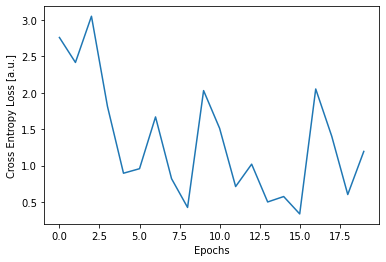

In [330]:
plt.plot(np.arange(NUM_EPOCHS).astype(int), loss_values)
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss [a.u.]")

You should find that the loss drops as you train the network with more and more epochs. If not, what could be the possible cause of it?

Next, let's plot the accuracy curve. That is, the accuracy with respect to epochs:

Text(0, 0.5, 'Classification Accuracy [%]')

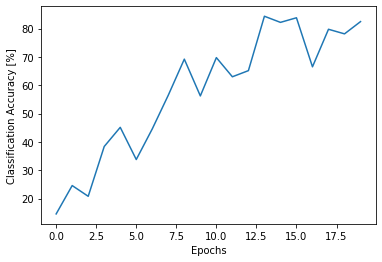

In [331]:
plt.plot(np.arange(NUM_EPOCHS).astype(int), np.array(accuracy_values)*100.0)
plt.xlabel("Epochs")
plt.ylabel("Classification Accuracy [%]")

Lastly, let's plot the confusion matrix:

Text(0, 0.5, 'Ground Truth')

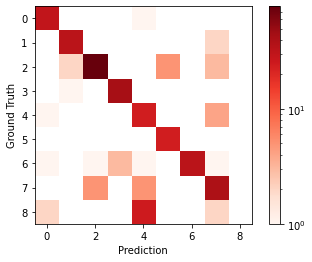

In [332]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
plt.imshow(cm,norm=matplotlib.colors.LogNorm(), cmap = "Reds") #Making the z-direction logarithmic scale
plt.colorbar()
plt.xlabel("Prediction")
plt.ylabel("Ground Truth")